<h1 align='center'>Classification Animal Faces</h1>
<h1 align='center'>VGG-16 With Traditional Machine Learning Algorithm</h1>

# Download Data From Driver

In [1]:
%cd '/content'
!gdown https://drive.google.com/uc?id=1uG05PyClwmZWgxYdUFztDYUB7GMZ8L-a

/content
Downloading...
From: https://drive.google.com/uc?id=1uG05PyClwmZWgxYdUFztDYUB7GMZ8L-a
To: /content/Animal Face Dataset.zip
100% 127M/127M [00:00<00:00, 206MB/s]


In [ ]:
!unzip '/content/Animal Face Dataset.zip'

# Import Libary

In [3]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image

# Statistics and Data Processing

In [4]:
labels = os.listdir('/content/Animal Face Dataset')
source_path = '/content/Animal Face Dataset'
join = os.path.join

In [5]:
for label in labels:
    animal_path = os.path.join(source_path, label)
    list_img_name = os.listdir(animal_path)
    list_img_name.sort()
    for index, img_name in enumerate(list_img_name):
        os.chdir(animal_path)
        os.rename(img_name, label + '_face_' + str(index + 1) + '.jpg')

In [6]:
for label in labels:
    animal_path = os.path.join(source_path, label)
    for image_name in os.listdir(animal_path):
        try:
            image = Image.open(os.path.join(animal_path,image_name))
            image = image.convert('RGB')
            na = np.array(image)
            result = Image.fromarray(na).save(os.path.join(animal_path,image_name))
        except:
            print(os.path.join(animal_path,image_name))
            os.remove(os.path.join(animal_path,image_name))

# Use VGG16 To Feature Selection

In [7]:
from keras.preprocessing.image import ImageDataGenerator
import seaborn

In [8]:
datagen = ImageDataGenerator()
generator = datagen.flow_from_directory(source_path, target_size=(224, 224), batch_size = 128, class_mode = 'sparse')

Found 2181 images belonging to 6 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

In [10]:
model_VGG16 = VGG16()

553476096/553467096 [==============================] - 3s 0us/step


In [11]:
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
from keras import backend
backend.learning_phase()

0

## Take Fully-connected Layer

In [13]:
from tensorflow.keras.models import Model
layer_fc2 = Model(inputs=model_VGG16.input, outputs=model_VGG16.get_layer('fc2').output)

In [14]:
layer_fc2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Flatten Vector

In [15]:
image = np.zeros((1,4096))
label = np.zeros((1))
for i, (inputs_batch, labels_batch) in enumerate(generator):
  features_batch = layer_fc2.predict(inputs_batch)
  image = np.concatenate((image, features_batch), axis = 0)
  label = np.concatenate((label,labels_batch), axis = 0)
  if i* generator.batch_size >= generator.samples :
    break

In [16]:
image_data = image[1:1160,:]
label_data = label[1:1160]

# Split Data

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_data, label_data, test_size=0.3, random_state=42)

# Training and Evaluation Model

## Function Plot Confusion Matrix

In [18]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Model Support Vector Machine (SVM)

In [27]:
from sklearn import svm
model_SVM = svm.SVC()
model_SVM.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [28]:
y_predict = model_SVM.predict(X_test)

              precision    recall  f1-score   support

         dog       1.00      0.98      0.99        56
         fox       0.94      1.00      0.97        67
        lion       0.98      1.00      0.99        65
        wolf       1.00      0.98      0.99        57
       tiger       0.98      1.00      0.99        49
         cat       1.00      0.93      0.96        54

    accuracy                           0.98       348
   macro avg       0.98      0.98      0.98       348
weighted avg       0.98      0.98      0.98       348



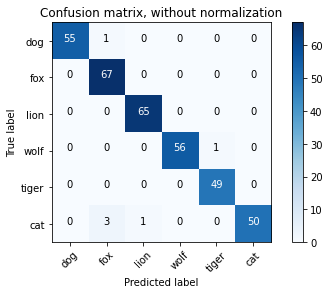

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_predict, target_names=labels))

cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

## Model LogisticRegression

In [30]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
y_predict = logistic_regression_model.predict(X_test)

              precision    recall  f1-score   support

         dog       1.00      0.98      0.99        56
         fox       0.97      0.99      0.98        67
        lion       1.00      1.00      1.00        65
        wolf       1.00      0.98      0.99        57
       tiger       0.98      1.00      0.99        49
         cat       0.98      0.98      0.98        54

    accuracy                           0.99       348
   macro avg       0.99      0.99      0.99       348
weighted avg       0.99      0.99      0.99       348



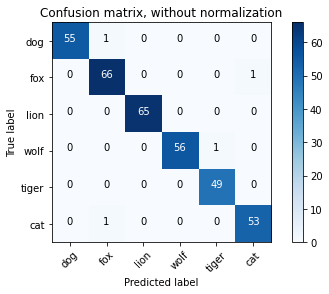

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_predict, target_names=labels))

cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')